# LightGBM Model Analysis

This notebook analyses the results of the Optuna training study used to train an "optimal" LightGBM model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import *
from tqdm import tqdm
import numpy as np
import seaborn as sns
sns.set()

In [2]:
train_data = np.genfromtxt('./train.csv', delimiter=',', skip_header=1)
val_data = np.genfromtxt('./val.csv', delimiter=',', skip_header=1)

y_true = val_data[:,:1].flatten()

## Training Baseline Models

Training a simple [gaussian naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), and a [logistic regession classifier](https://en.wikipedia.org/wiki/Logistic_regression) to use as baseline comparisons to the LightGBM model.

In [3]:
gnb = GaussianNB()
gnb_y_pred = np.array([x[1] for x in gnb.fit(train_data[:,1:], train_data[:,:1].flatten()).predict_proba(val_data[:,1:])])

In [4]:
lr = LogisticRegression(verbose=1, random_state=0)
lr_y_pred = np.array([x[1] for x in lr.fit(train_data[:,1:], train_data[:,:1].flatten()).predict_proba(val_data[:,1:])])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s finished


## Optuna Study Analysis

Study contains 25 trials (25 completed, 0 pruned)
Best trial: #13


number                                              13
value                                          0.46157
datetime_start              2020-06-15 14:24:26.439126
datetime_complete           2020-06-15 14:28:18.411598
duration                     0 days 00:03:51.972472000
params_bagging_fraction                       0.861753
params_bagging_freq                                  5
params_feature_fraction                       0.709083
params_max_depth                                    46
params_min_child_samples                           134
params_num_leaves                                   15
state                                         COMPLETE
Name: 13, dtype: object

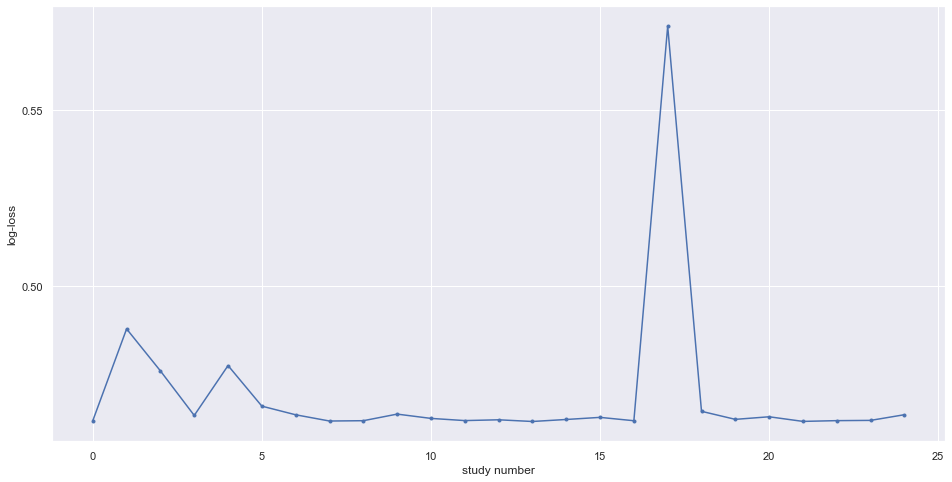

In [5]:
# load in Optuna results
study_df = pd.read_csv('./optuna_study.csv', index_col=0)
best_trial_id = study_df['value'].idxmin()
best_trial = study_df.iloc[best_trial_id]

print('Study contains {} trials ({} completed, {} pruned)'.format(
    len(study_df), 
    study_df['state'].value_counts()['COMPLETE'],
    study_df['state'].value_counts()['PRUNED'] if 'PRUNED' in study_df['state'].value_counts() else 0
))
print('Best trial: #{}'.format(best_trial_id))
display(best_trial)

plt.figure(figsize=(16,8))
plt.plot(study_df['number'], study_df['value'], marker='.')
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.xlabel('study number')
plt.ylabel('log-loss')
plt.show()

### Parameter Impact

Analysing the effect of changing individual parameters on final auc.

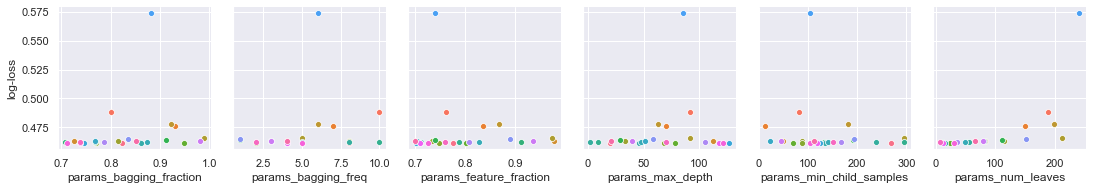

In [6]:
params = [col for col in study_df.columns if col.startswith('params_')]
g = sns.pairplot(
    data=study_df,
    y_vars=['value'], 
    x_vars=params,
    hue='number',
    kind='scatter',
    markers='o'
)
g.set(ylabel='log-loss')
g._legend.remove()
plt.show()

## Best Model Analysis

In [7]:
best_model_file = './LightGBM_model.txt'
with open(best_model_file, 'r', newline='\n') as f:
    best_model = lgb.Booster(model_str=f.read())

Finished loading model, total used 1491 iterations


In [8]:
best_model_y_pred = best_model.predict(val_data[:,1:])

### Train/Val Learning Curve

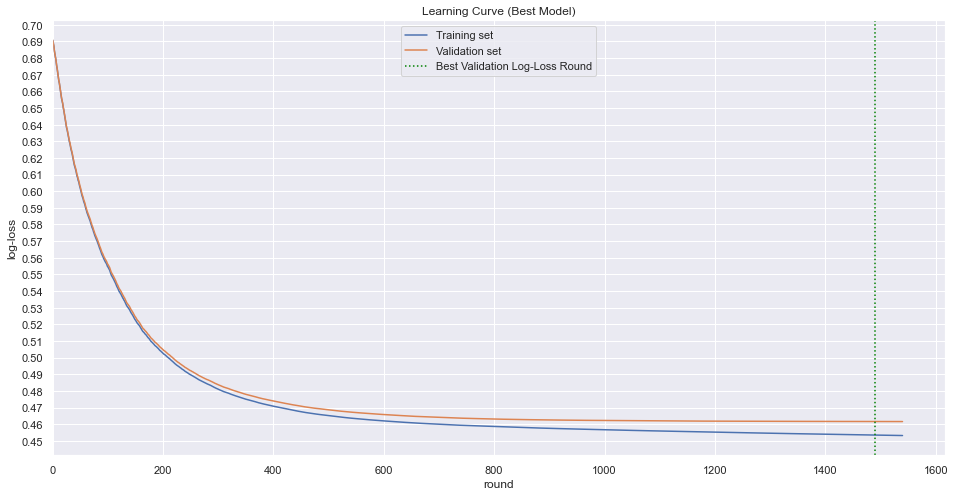

In [9]:
# load in trial csv
best_trial_id = study_df['value'].idxmin()
best_trial_df = pd.read_csv('./trials/trial_{:03d}.csv'.format(best_trial_id))

plt.figure(figsize=(16,8))
best_round_result = best_trial_df.loc[best_trial_df['val_logloss'] == best_trial['value']]
g = sns.lineplot(x=best_trial_df['round'], y=best_trial_df['train_logloss'])
g = sns.lineplot(x=best_trial_df['round'], y=best_trial_df['val_logloss'])
g.xaxis.set_major_locator(ticker.MultipleLocator(200))
g.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
g.set(xlabel='round', ylabel='log-loss')
plt.axvline(int(best_round_result['round']), 0, 1, c='green', linestyle=':')
plt.title('Learning Curve (Best Model)')
plt.xlim(-1,)
g.legend(labels=['Training set','Validation set', 'Best Validation Log-Loss Round'])
plt.show()

### Performance Summary

After setting the decision threshold to 0.5 (which should be the case for a properly calibrated model where we care about both positive and negative classifications), it is possible to extract true positive, false positive, true negative and false negative counts on the validation set.

In [10]:
print('Classification report (baseline naive Bayes model, threshold = 0.5):\n')
print(classification_report(y_true, (gnb_y_pred >= 0.5), target_names=['CT round win', 'T round win']))

print('\n')

print('Classification report (baseline logistic regression model, threshold = 0.5):\n')
print(classification_report(y_true, (lr_y_pred >= 0.5), target_names=['CT round win', 'T round win']))

print('\n')

print('Classification report (best model, threshold = 0.5):\n')
print(classification_report(y_true, (best_model_y_pred >= 0.5), target_names=['CT round win', 'T round win']))

Classification report (baseline naive Bayes model, threshold = 0.5):

              precision    recall  f1-score   support

CT round win       0.81      0.58      0.67    192327
 T round win       0.65      0.85      0.74    179517

    accuracy                           0.71    371844
   macro avg       0.73      0.72      0.71    371844
weighted avg       0.73      0.71      0.71    371844



Classification report (baseline logistic regression model, threshold = 0.5):

              precision    recall  f1-score   support

CT round win       0.76      0.74      0.75    192327
 T round win       0.73      0.75      0.74    179517

    accuracy                           0.74    371844
   macro avg       0.74      0.74      0.74    371844
weighted avg       0.74      0.74      0.74    371844



Classification report (best model, threshold = 0.5):

              precision    recall  f1-score   support

CT round win       0.75      0.79      0.77    192327
 T round win       0.76      0.

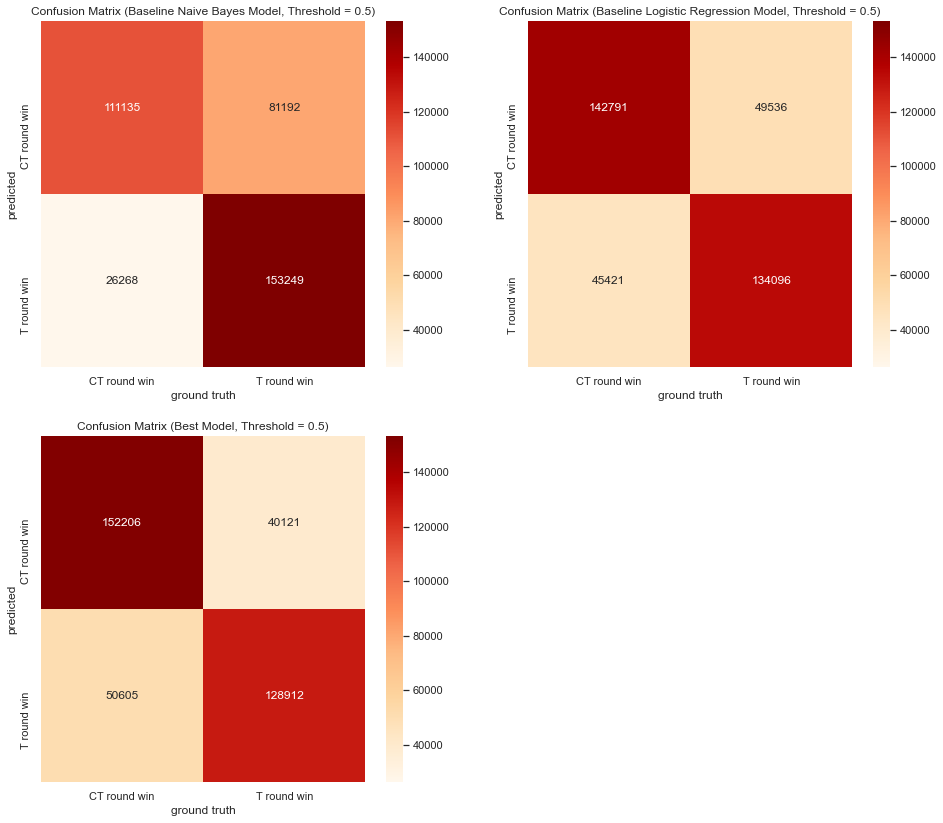

In [11]:
plt.figure(figsize = (16,14))

cm1 = confusion_matrix(y_true, (gnb_y_pred >= 0.5))
cm2 = confusion_matrix(y_true, (lr_y_pred >= 0.5))
cm3 = confusion_matrix(y_true, (best_model_y_pred >= 0.5))

min_val = min(np.min(cm1), min(np.min(cm2), np.min(cm3)))
max_val = max(np.max(cm1), max(np.max(cm2), np.max(cm3)))

ax1 = plt.subplot(2,2,1)

cm_df = pd.DataFrame(cm1, index=['CT round win', 'T round win'], columns=['CT round win', 'T round win'])
plt.title('Confusion Matrix (Baseline Naive Bayes Model, Threshold = 0.5)')
sns.heatmap(cm_df, annot=True, cmap='OrRd', fmt='g', vmin=min_val, vmax=max_val)
plt.xlabel('ground truth')
plt.ylabel('predicted')

ax2 = plt.subplot(2,2,2)

cm_df = pd.DataFrame(cm2, index=['CT round win', 'T round win'], columns=['CT round win', 'T round win'])
plt.title('Confusion Matrix (Baseline Logistic Regression Model, Threshold = 0.5)')
sns.heatmap(cm_df, annot=True, cmap='OrRd', fmt='g', vmin=min_val, vmax=max_val)
plt.xlabel('ground truth')
plt.ylabel('predicted')

ax2 = plt.subplot(2,2,3)

cm_df = pd.DataFrame(cm3, index=['CT round win', 'T round win'], columns=['CT round win', 'T round win'])
plt.title('Confusion Matrix (Best Model, Threshold = 0.5)')
sns.heatmap(cm_df, annot=True, cmap='OrRd', fmt='g', vmin=min_val, vmax=max_val)
plt.xlabel('ground truth')
plt.ylabel('predicted')

plt.show()

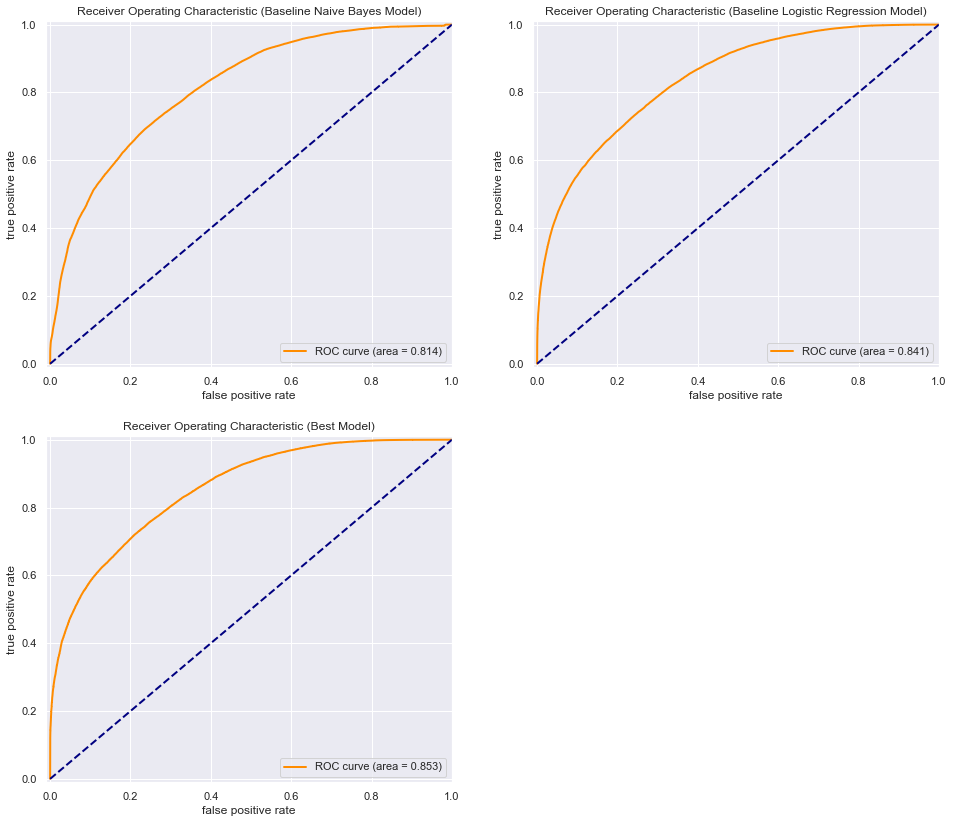

In [12]:
plt.figure(figsize = (16,14))

ax1 = plt.subplot(2,2,1)

fpr, tpr, _ = roc_curve(y_true, gnb_y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operating Characteristic (Baseline Naive Bayes Model)')
plt.legend(loc="lower right")

ax2 = plt.subplot(2,2,2)

fpr, tpr, _ = roc_curve(y_true, lr_y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operating Characteristic (Baseline Logistic Regression Model)')
plt.legend(loc="lower right")

ax3 = plt.subplot(2,2,3)

fpr, tpr, _ = roc_curve(y_true, best_model_y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operating Characteristic (Best Model)')
plt.legend(loc="lower right")

plt.show()

### Probability Calibration

Brier score (baseline naive Bayes model): 0.18136040394174302
Brier score (baseline logistic regression model): 0.1622947082138664
Brier score (best model): 0.1553108159582093


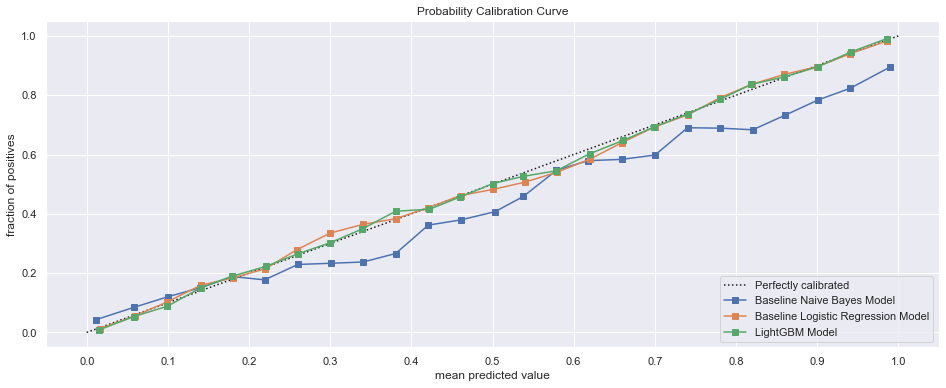

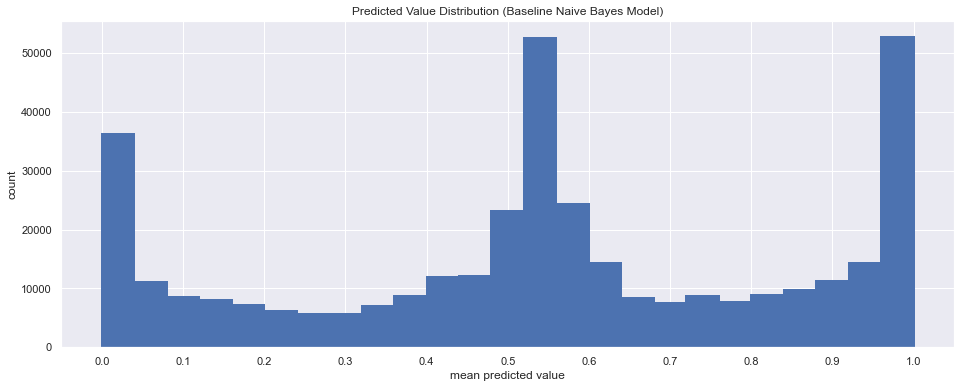

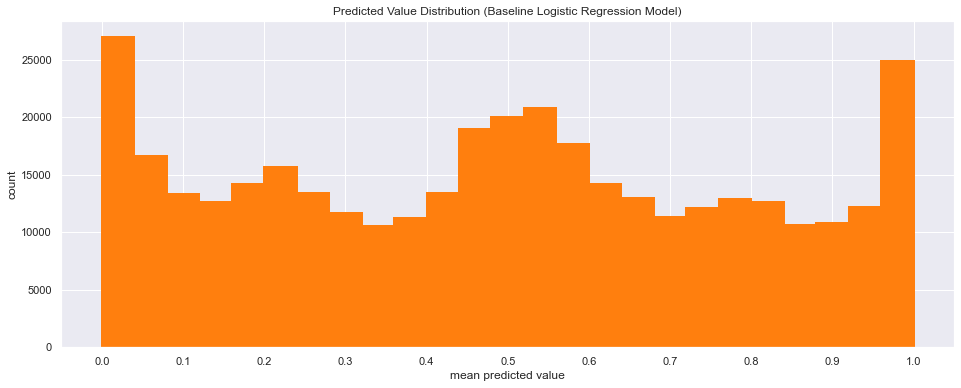

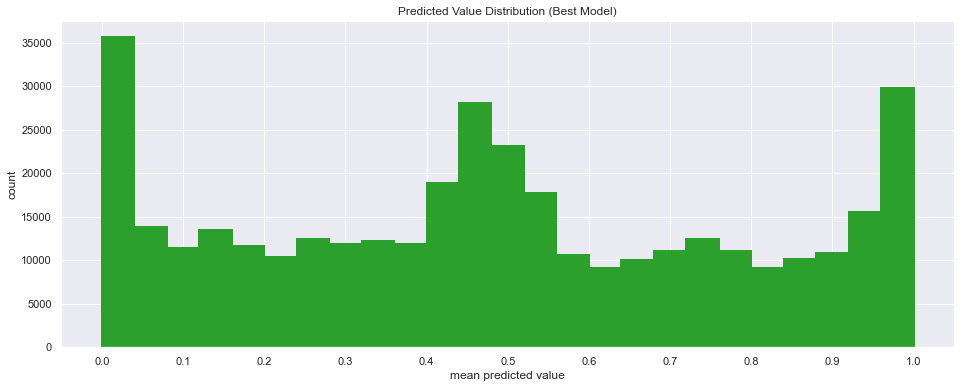

In [13]:
print('Brier score (baseline naive Bayes model):', brier_score_loss(y_true, gnb_y_pred))
print('Brier score (baseline logistic regression model):', brier_score_loss(y_true, lr_y_pred))
print('Brier score (best model):', brier_score_loss(y_true, best_model_y_pred))

bins = 25

plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, gnb_y_pred, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Baseline Naive Bayes Model')

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, lr_y_pred, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Baseline Logistic Regression Model')

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, best_model_y_pred, n_bins=bins)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='LightGBM Model')

plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('fraction of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(gnb_y_pred, range=(0, 1), bins=bins, histtype="step", lw=2, fill=True)
plt.title('Predicted Value Distribution (Baseline Naive Bayes Model)')
plt.ylabel('count')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(lr_y_pred, range=(0, 1), bins=bins, histtype="step", lw=2, fill=True, color='tab:orange')
plt.title('Predicted Value Distribution (Baseline Logistic Regression Model)')
plt.ylabel('count')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(best_model_y_pred, range=(0, 1), bins=bins, histtype="step", lw=2, fill=True, color='tab:green')
plt.title('Predicted Value Distribution (Best Model)')
plt.ylabel('count')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

The following two plots compare the average performance of the baseline models and the best model at 10 second time intervals during a complete round, and only after the bomb plant. This is measured using the brier score between between the true round winner (0.0 = CT, 1.0 = T) and the predicted round winner probability value. Understandably, error at the start of the round is quite high - in practice, many rounds are close to 50/50 when they start.

**Note:** brier score is a measure of error (fundamentally equivalent to mean squared error), so lower values are better.

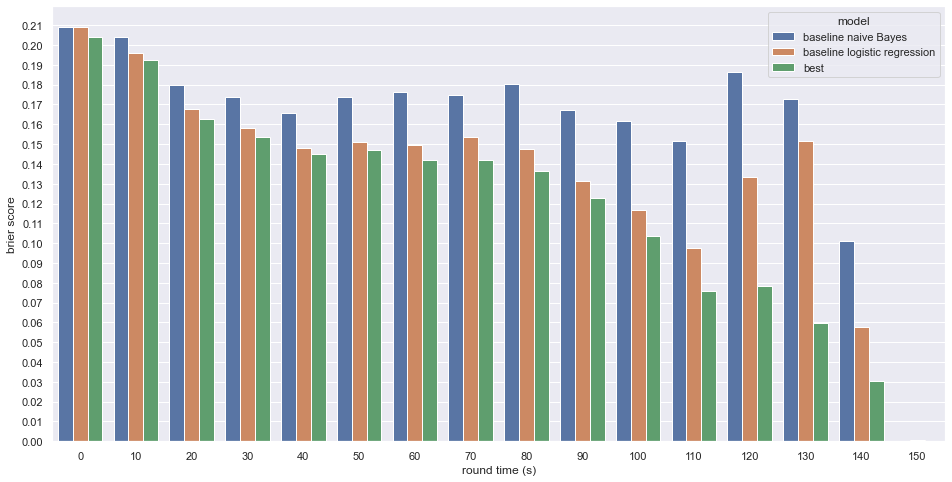

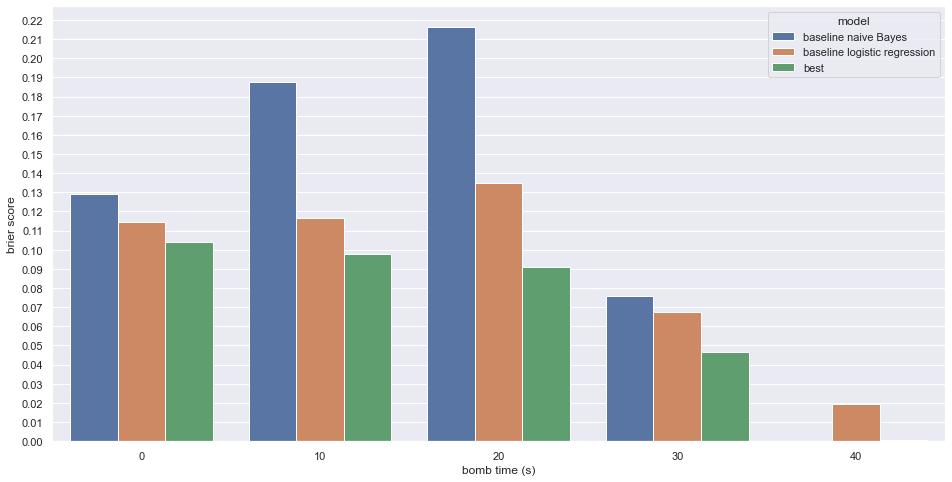

In [20]:
BIN_SIZE=10
roundtime_performance_baseline_gnb_df = pd.DataFrame({
    'model': 'baseline naive Bayes',
    'bin': (np.floor(val_data[:,7]/BIN_SIZE) * BIN_SIZE).astype(int),
    'bomb_bin': (np.floor(val_data[:,8]/BIN_SIZE) * BIN_SIZE).astype(int),
    'round_time': val_data[:,7],
    'bomb_time': val_data[:,8],
    'squared_error': np.square(gnb_y_pred-y_true)
})

roundtime_performance_baseline_lr_df = pd.DataFrame({
    'model': 'baseline logistic regression',
    'bin': (np.floor(val_data[:,7]/BIN_SIZE) * BIN_SIZE).astype(int),
    'bomb_bin': (np.floor(val_data[:,8]/BIN_SIZE) * BIN_SIZE).astype(int),
    'round_time': val_data[:,7],
    'bomb_time': val_data[:,8],
    'squared_error': np.square(lr_y_pred-y_true)
})

roundtime_performance_best_df = pd.DataFrame({
    'model': 'best',
    'bin': (np.floor(val_data[:,7]/BIN_SIZE) * BIN_SIZE).astype(int),
    'bomb_bin': (np.floor(val_data[:,8]/BIN_SIZE) * BIN_SIZE).astype(int),
    'round_time': val_data[:,7],
    'bomb_time': val_data[:,8],
    'squared_error': np.square(best_model_y_pred-y_true)
})

roundtime_performance_combined_df = pd.concat([
    roundtime_performance_baseline_gnb_df,
    roundtime_performance_baseline_lr_df,
    roundtime_performance_best_df
])

plt.figure(figsize=(16, 8))
sns.barplot(
    data=roundtime_performance_combined_df.groupby(['model','bin']).mean().reset_index(), 
    x='bin',
    y='squared_error', 
    hue='model',
    hue_order=['baseline naive Bayes', 'baseline logistic regression', 'best']
)
plt.ylabel('brier score')
plt.xlabel('round time (s)')
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.show()

plt.figure(figsize=(16, 8))
sns.barplot(
    data=roundtime_performance_combined_df[
        roundtime_performance_combined_df['bomb_time'] > 0
    ].groupby(['model','bomb_bin']).mean().reset_index(),
    x='bomb_bin',
    y='squared_error', 
    hue='model',
    hue_order=['baseline naive Bayes', 'baseline logistic regression', 'best']
)
plt.ylabel('brier score')
plt.xlabel('bomb time (s)')
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.show()

## Prediction Variance Between LightGBM Models

Calculating the expected amount of variance between predictions from different models from the study. As in, given the same input data, how much does the output prediction vary between different models.

This gives an idea of how "specific" the trained model is - an estimation of how much each prediction would vary if the model was trained slightly differently. The smaller the variance, the better.

In [15]:
# just use a sample of 10% of the validation data
val_data_sample = val_data[:,1:][np.random.choice(val_data[:,1:].shape[0], int(len(val_data[:,1:]) * 0.10), replace=False), :]

preds = np.empty(shape=(len(val_data_sample), len(study_df)))
for i, trial_no in enumerate(tqdm(study_df.index.tolist())):
    model_file = './models/LightGBM_model_{:03d}.txt'.format(trial_no)
    with open(model_file, 'r', newline='\n') as f:
        model = lgb.Booster(model_str=f.read(), silent=True)
    preds[:,i] = model.predict(val_data_sample)

variances = np.apply_along_axis(lambda a: a.var(), axis=1, arr=preds)
stddevs = np.apply_along_axis(lambda a: a.std(), axis=1, arr=preds)
print('Mean prediction variance: {:.6f}, standard deviation: {:.6f}'.format(variances.mean(), stddevs.mean()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.40it/s]


Mean prediction variance: 0.001767, standard deviation: 0.037487
